# Figure 1

/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


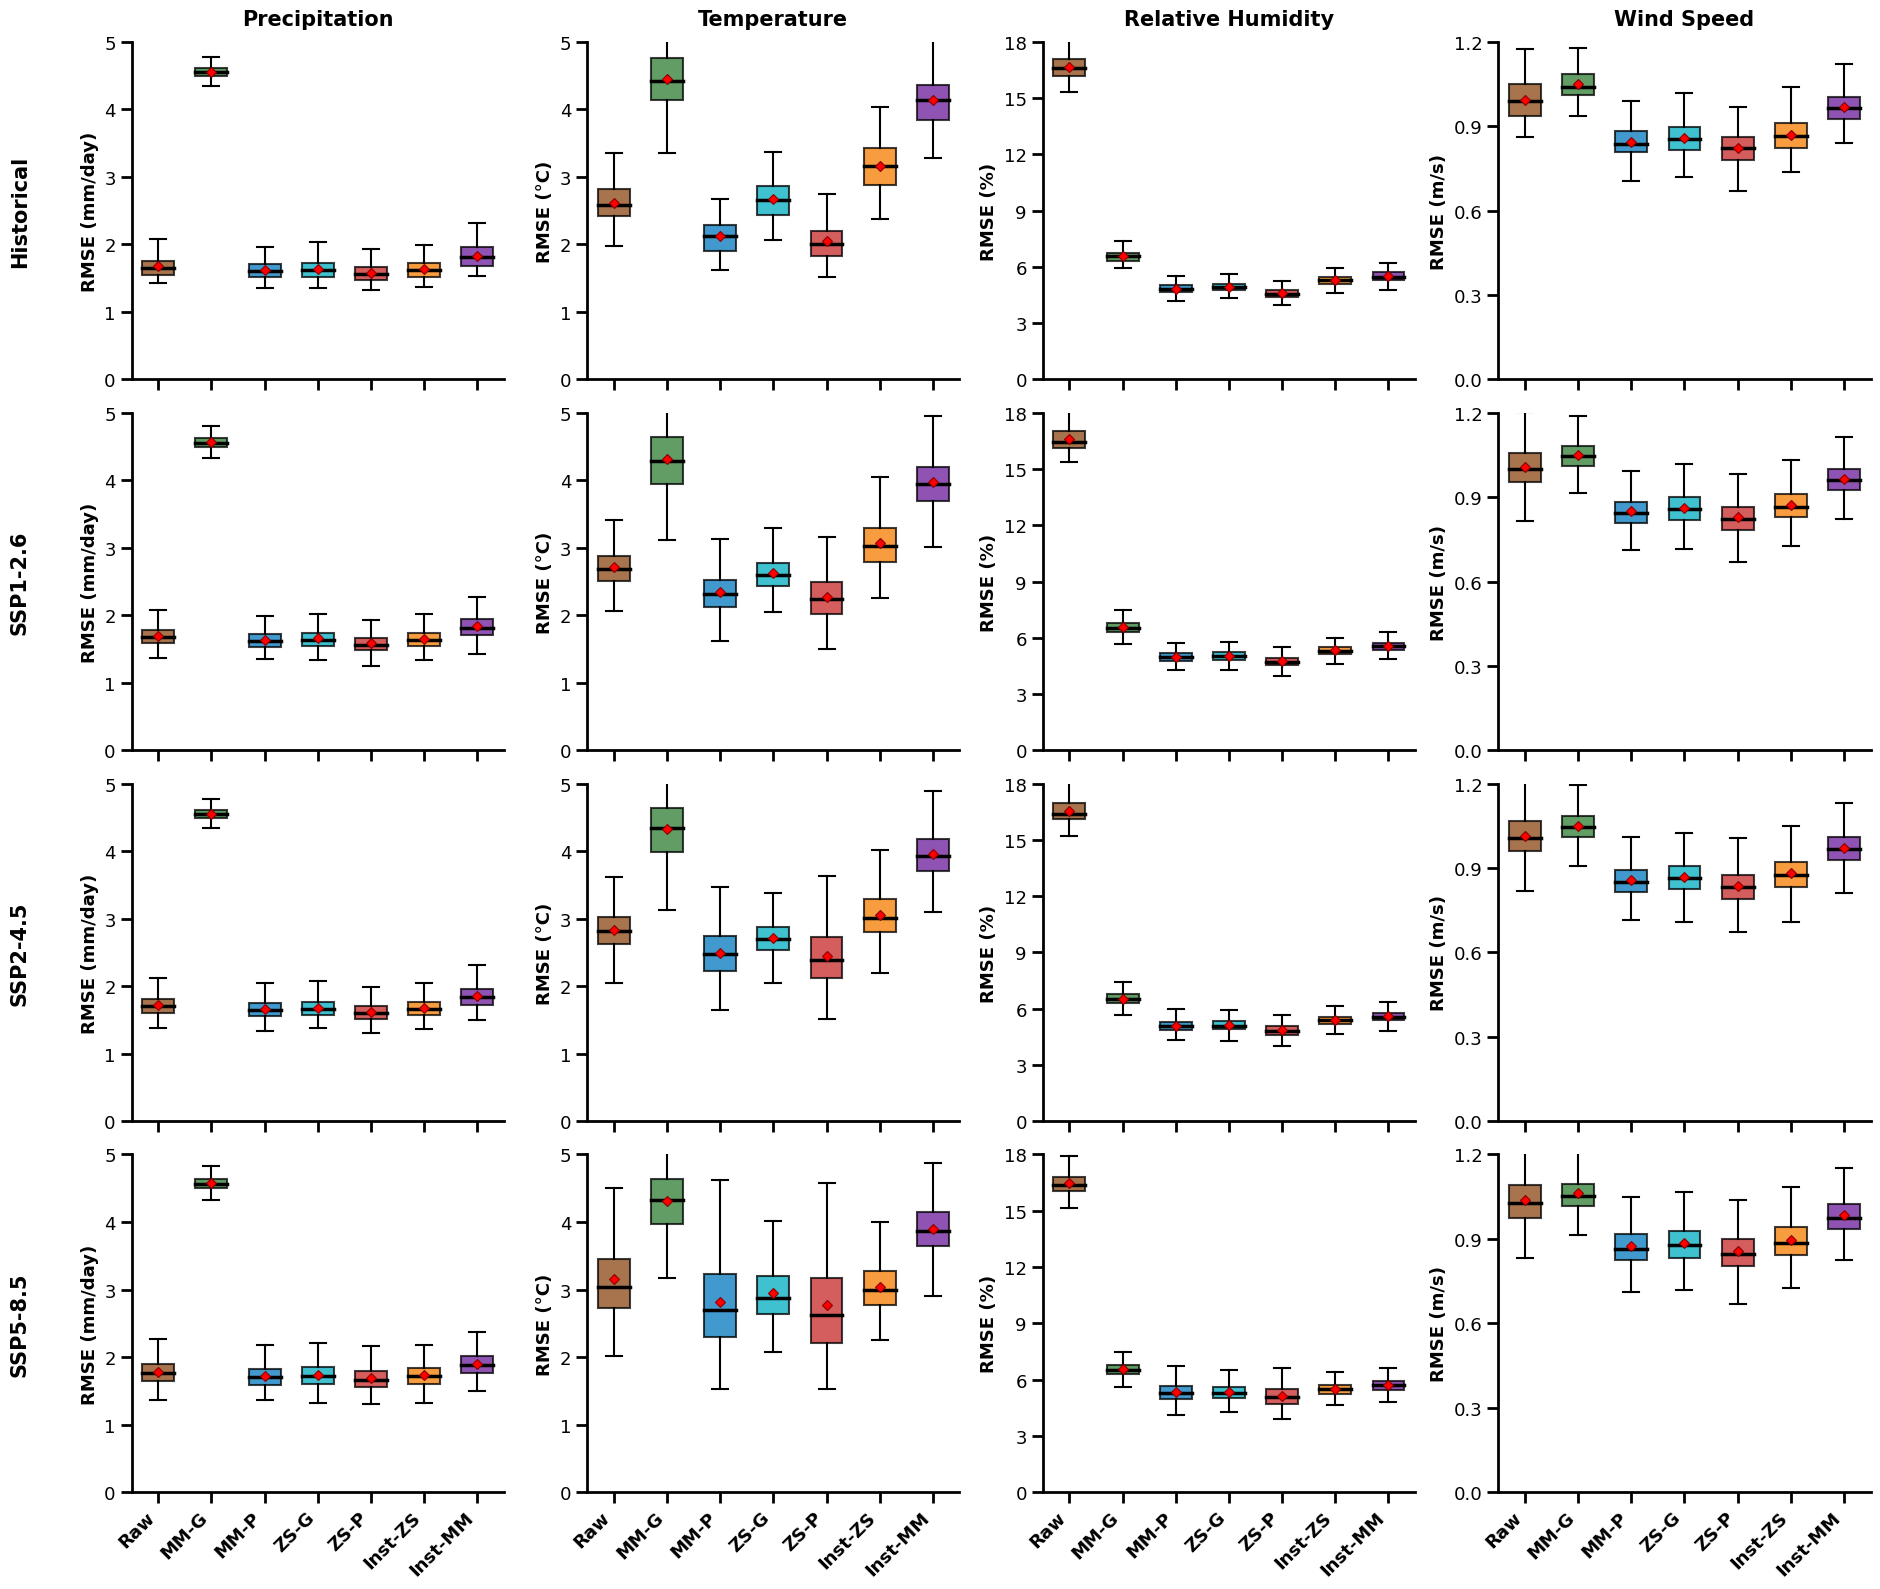

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
from scipy.stats import pearsonr

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("../evaluation_results")
figures_dir = Path("../Figures")

variables = ['pr', 'tas', 'hurs', 'sfcWind']
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']
normalizations = ['none', 'minmax_global', 'minmax_pixel', 'zscore_global', 
                  'zscore_pixel', 'instance_zscore', 'instance_minmax']

# Variable configuration
var_config = {
    'pr': {'label': 'Precipitation', 'unit': 'mm/day'},
    'tas': {'label': 'Temperature', 'unit': '°C'},
    'hurs': {'label': 'Relative Humidity', 'unit': '%'},
    'sfcWind': {'label': 'Wind Speed', 'unit': 'm/s'}
}

# Manual y-axis limits and ticks
y_axis_config = {
    'pr': {'lim': (0, 5), 'ticks': [0, 1, 2, 3, 4, 5]},
    'tas': {'lim': (0, 5), 'ticks': [0, 1, 2, 3, 4, 5]},
    'hurs': {'lim': (0, 18), 'ticks': [0, 3, 6, 9, 12, 15, 18]},
    'sfcWind': {'lim': (0, 1.2), 'ticks': [0, 0.3, 0.6, 0.9, 1.2]}
}

# Normalization labels
norm_labels = {
    'none': 'Raw',
    'minmax_global': 'MM-G',
    'minmax_pixel': 'MM-P',
    'zscore_global': 'ZS-G',
    'zscore_pixel': 'ZS-P',
    'instance_zscore': 'Inst-ZS',
    'instance_minmax': 'Inst-MM'
}

# Scenario labels
scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Colors for models
model_colors = {
    'none': '#8B4513',           # Saddle Brown
    'minmax_global': '#2E7D32',  # Dark Green
    'minmax_pixel': '#0277BD',   # Dark Blue
    'zscore_global': '#00ACC1',  # Cyan
    'zscore_pixel': '#C62828',   # Dark Red
    'instance_zscore': '#F57C00', # Dark Orange
    'instance_minmax': '#6A1B9A'  # Dark Purple
}

# ----------------------------
# Functions
# ----------------------------
def compute_spatial_rmse_timeseries(predictions, groundtruth):
    """
    Calculate spatial RMSE for each time point.
    
    Args:
        predictions: (time, lat, lon)
        groundtruth: (time, lat, lon)
    
    Returns:
        Array of RMSE values, one per time step
    """
    n_time = predictions.shape[0]
    rmse_values = []
    
    for t in range(n_time):
        pred_2d = predictions[t].flatten()
        gt_2d = groundtruth[t].flatten()
        
        # RMSE at this time step
        rmse = np.sqrt(np.mean((pred_2d - gt_2d)**2))
        rmse_values.append(rmse)
    
    return np.array(rmse_values)

# ----------------------------
# Load data and compute metrics
# ----------------------------
# Storage: metrics[variable][scenario][normalization] = rmse_timeseries
metrics = {var: {scen: {} for scen in scenarios} for var in variables}

for var in variables:
    
    for scenario in scenarios:
        
        # Load evaluation results
        results_file = results_dir / f"{var}_evaluation_{scenario}.nc"
        ds = xr.open_dataset(results_file)
        
        # Get ground truth
        gt_data = ds['groundtruth'].values  # Shape: (time, lat, lon)
        
        # Compute metrics for each normalization
        for norm in normalizations:
            pred_key = f'pred_{norm}'
            
            if pred_key not in ds:
                continue
            
            pred_data = ds[pred_key].values  # Shape: (time, lat, lon)
            
            # Calculate RMSE timeseries
            rmse_ts = compute_spatial_rmse_timeseries(pred_data, gt_data)
            metrics[var][scenario][norm] = rmse_ts
        

# ----------------------------
# Create visualization
# ----------------------------
fig, axes = plt.subplots(4, 4, figsize=(20, 16))

for row, scenario in enumerate(scenarios):
    for col, var in enumerate(variables):
        ax = axes[row, col]
        
        # Prepare data for box plot
        box_data = []
        positions = []
        colors = []
        
        for i, norm in enumerate(normalizations):
            if norm in metrics[var][scenario]:
                rmse_data = metrics[var][scenario][norm]
                box_data.append(rmse_data)
                positions.append(i + 1)
                colors.append(model_colors[norm])
        
        # Create box plot
        bp = ax.boxplot(box_data, positions=positions, widths=0.6,
                        patch_artist=True, showfliers=False,
                        medianprops=dict(color='black', linewidth=2.5),
                        boxprops=dict(linewidth=1.5),
                        whiskerprops=dict(linewidth=1.5),
                        capprops=dict(linewidth=1.5))
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.75)
        
        # Add mean marker (red diamond)
        for i, data_values in enumerate(box_data):
            mean_val = np.mean(data_values)
            ax.plot(positions[i], mean_val, 'D', color='red', 
                   markersize=5, zorder=10, markeredgecolor='darkred', 
                   markeredgewidth=0.8)
        
        # Formatting
        ax.set_xticks(positions)
        
        # X-axis labels only on bottom row
        if row == 3:
            ax.set_xticklabels([norm_labels[norm] for norm in normalizations], 
                              rotation=45, ha='right', fontsize=11, fontweight='bold')
        else:
            ax.set_xticklabels([])
        
        # Set y-axis limits and ticks manually
        ax.set_ylim(y_axis_config[var]['lim'])
        ax.set_yticks(y_axis_config[var]['ticks'])
        
        # Y-axis label
        ax.set_ylabel(f'RMSE ({var_config[var]["unit"]})', 
                     fontsize=13, fontweight='bold')
        
        # Variable title on top row
        if row == 0:
            ax.set_title(var_config[var]['label'], 
                        fontsize=15, fontweight='bold', pad=12)
        
        # Scenario label on leftmost column
        if col == 0:
            ax.text(-0.30, 0.5, scenario_labels[scenario], 
                   transform=ax.transAxes,
                   fontsize=15, fontweight='bold',
                   rotation=90, va='center', ha='center',
                   color='black')
        
        # ONLY show left and bottom spines (like your image)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        
        # Set spine colors to black and increase width
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        
        # Increase tick size (length and width) and fontsize
        ax.tick_params(axis='both', which='major', 
                      labelsize=13,
                      length=8,
                      width=2,
                      colors='black')

plt.tight_layout(rect=[0.06, 0, 1, 1.0])

# Save figure
output_file = figures_dir / "03_spatial_rmse_boxplots.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')

# Figure 2

/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


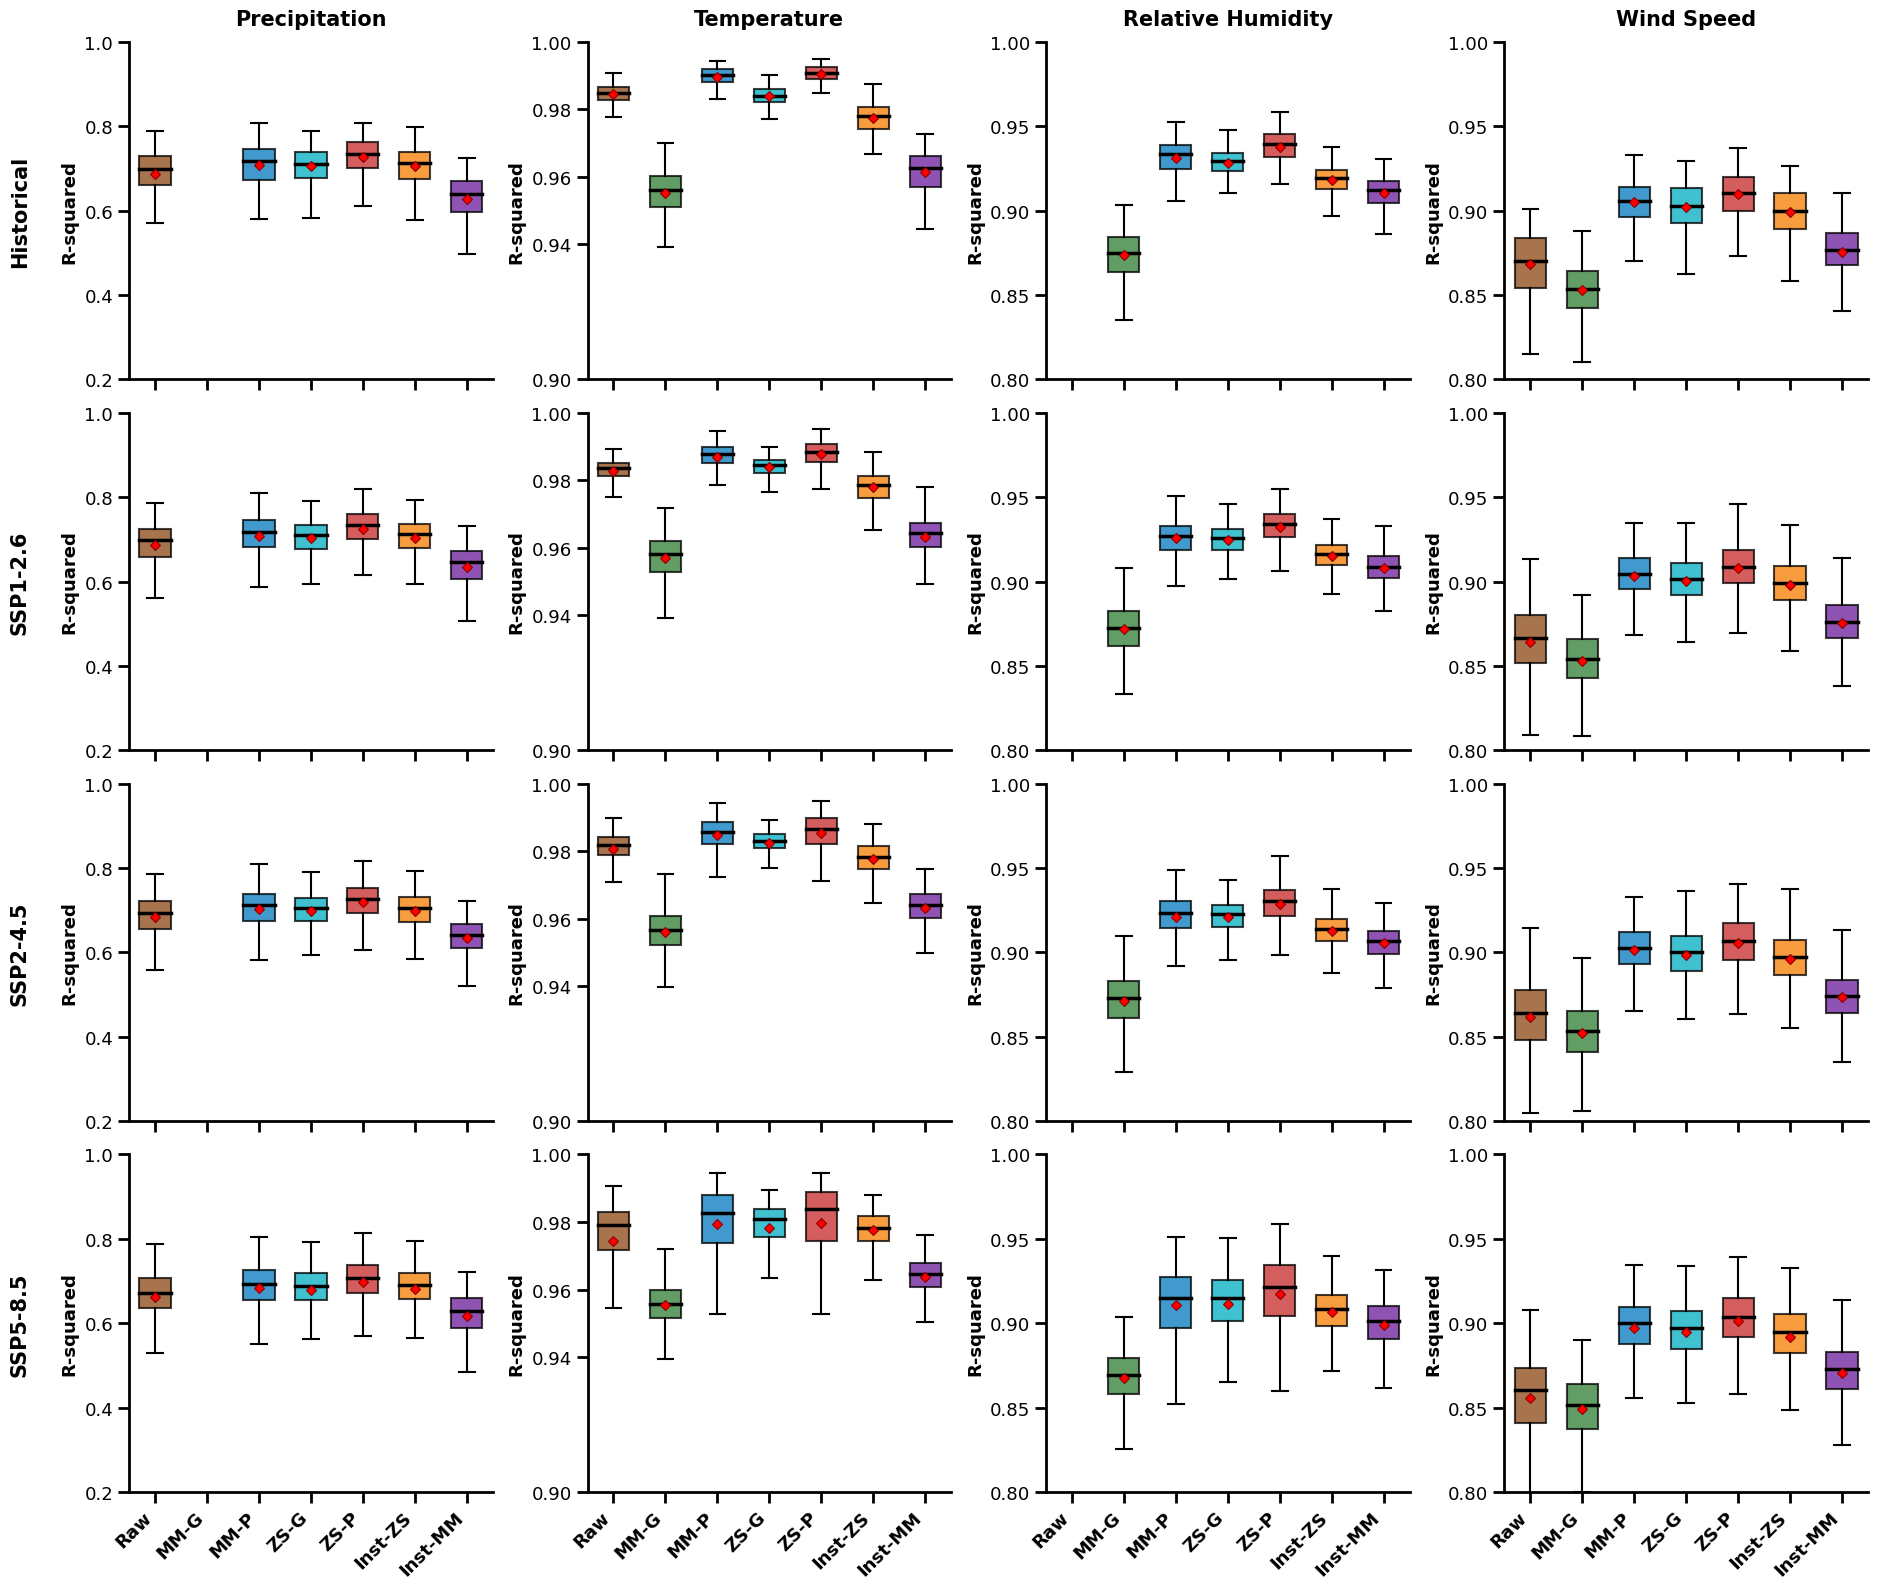

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("../evaluation_results")
figures_dir = Path("../Figures")

variables = ['pr', 'tas', 'hurs', 'sfcWind']
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']
normalizations = ['none', 'minmax_global', 'minmax_pixel', 'zscore_global', 
                  'zscore_pixel', 'instance_zscore', 'instance_minmax']

# Variable configuration
var_config = {
    'pr': {'label': 'Precipitation', 'unit': ''},
    'tas': {'label': 'Temperature', 'unit': ''},
    'hurs': {'label': 'Relative Humidity', 'unit': ''},
    'sfcWind': {'label': 'Wind Speed', 'unit': ''}
}

# Manual y-axis limits and ticks for R² (typically 0 to 1)
y_axis_config = {
    'pr': {'lim': (0.2, 1), 'ticks': [0.2, 0.4, 0.6, 0.8, 1.0]},
    'tas': {'lim': (0.9, 1), 'ticks': [0.90, 0.94, 0.96, 0.98, 1.0]},
    'hurs': {'lim': (0.8, 1), 'ticks': [0.8, 0.85, 0.9, 0.95, 1.0]},
    'sfcWind': {'lim': (0.8, 1), 'ticks': [0.8, 0.85, 0.9, 0.95, 1.0]}
}

# Normalization labels
norm_labels = {
    'none': 'Raw',
    'minmax_global': 'MM-G',
    'minmax_pixel': 'MM-P',
    'zscore_global': 'ZS-G',
    'zscore_pixel': 'ZS-P',
    'instance_zscore': 'Inst-ZS',
    'instance_minmax': 'Inst-MM'
}

# Scenario labels
scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Colors for models
model_colors = {
    'none': '#8B4513',           # Saddle Brown
    'minmax_global': '#2E7D32',  # Dark Green
    'minmax_pixel': '#0277BD',   # Dark Blue
    'zscore_global': '#00ACC1',  # Cyan
    'zscore_pixel': '#C62828',   # Dark Red
    'instance_zscore': '#F57C00', # Dark Orange
    'instance_minmax': '#6A1B9A'  # Dark Purple
}

# ----------------------------
# Functions
# ----------------------------
def compute_spatial_r2_timeseries(predictions, groundtruth):
    """
    Calculate spatial R² (coefficient of determination) for each time point.
    
    R² = 1 - SS_res / SS_tot
    where SS_res = sum((y - y_pred)^2)
          SS_tot = sum((y - y_mean)^2)
    
    Args:
        predictions: (time, lat, lon)
        groundtruth: (time, lat, lon)
    
    Returns:
        Array of R² values, one per time step
    """
    n_time = predictions.shape[0]
    r2_values = []
    
    for t in range(n_time):
        pred_2d = predictions[t].flatten()
        gt_2d = groundtruth[t].flatten()
        
        # Calculate R²
        ss_res = np.sum((gt_2d - pred_2d)**2)
        ss_tot = np.sum((gt_2d - np.mean(gt_2d))**2)
        
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        r2_values.append(r2)
    
    return np.array(r2_values)

# ----------------------------
# Load data and compute metrics
# ----------------------------

# Storage: metrics[variable][scenario][normalization] = r2_timeseries
metrics = {var: {scen: {} for scen in scenarios} for var in variables}

for var in variables:
    
    for scenario in scenarios:
        
        # Load evaluation results
        results_file = results_dir / f"{var}_evaluation_{scenario}.nc"
        ds = xr.open_dataset(results_file)
        
        # Get ground truth
        gt_data = ds['groundtruth'].values  # Shape: (time, lat, lon)
        
        # Compute metrics for each normalization
        for norm in normalizations:
            pred_key = f'pred_{norm}'
            
            if pred_key not in ds:
                continue
            
            pred_data = ds[pred_key].values  # Shape: (time, lat, lon)
            
            # Calculate R² timeseries
            r2_ts = compute_spatial_r2_timeseries(pred_data, gt_data)
            metrics[var][scenario][norm] = r2_ts
        
# ----------------------------
# Create visualization
# ----------------------------
fig, axes = plt.subplots(4, 4, figsize=(20, 16))

for row, scenario in enumerate(scenarios):
    for col, var in enumerate(variables):
        ax = axes[row, col]
        
        # Prepare data for box plot
        box_data = []
        positions = []
        colors = []
        
        for i, norm in enumerate(normalizations):
            if norm in metrics[var][scenario]:
                r2_data = metrics[var][scenario][norm]
                box_data.append(r2_data)
                positions.append(i + 1)
                colors.append(model_colors[norm])
        
        # Create box plot
        bp = ax.boxplot(box_data, positions=positions, widths=0.6,
                        patch_artist=True, showfliers=False,
                        medianprops=dict(color='black', linewidth=2.5),
                        boxprops=dict(linewidth=1.5),
                        whiskerprops=dict(linewidth=1.5),
                        capprops=dict(linewidth=1.5))
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.75)
        
        # Add mean marker (red diamond)
        for i, data_values in enumerate(box_data):
            mean_val = np.mean(data_values)
            ax.plot(positions[i], mean_val, 'D', color='red', 
                   markersize=5, zorder=10, markeredgecolor='darkred', 
                   markeredgewidth=0.8)
        
        # Formatting
        ax.set_xticks(positions)
        
        # X-axis labels only on bottom row
        if row == 3:
            ax.set_xticklabels([norm_labels[norm] for norm in normalizations], 
                              rotation=45, ha='right', fontsize=11, fontweight='bold')
        else:
            ax.set_xticklabels([])
        
        # Set y-axis limits and ticks manually
        ax.set_ylim(y_axis_config[var]['lim'])
        ax.set_yticks(y_axis_config[var]['ticks'])
        
        # Y-axis label
        ax.set_ylabel('R-squared', fontsize=13, fontweight='bold')
        
        # Variable title on top row
        if row == 0:
            ax.set_title(var_config[var]['label'], 
                        fontsize=15, fontweight='bold', pad=12)
        
        # Scenario label on leftmost column
        if col == 0:
            ax.text(-0.30, 0.5, scenario_labels[scenario], 
                   transform=ax.transAxes,
                   fontsize=15, fontweight='bold',
                   rotation=90, va='center', ha='center',
                   color='black')
        
        # ONLY show left and bottom spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        
        # Set spine colors to black and increase width
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        
        # Increase tick size (length and width) and fontsize
        ax.tick_params(axis='both', which='major', 
                      labelsize=13,
                      length=8,
                      width=2,
                      colors='black')

plt.tight_layout(rect=[0.06, 0, 1, 1.0])

# Save figure
output_file = figures_dir / "04_spatial_r2_boxplots.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')

# Figure 3

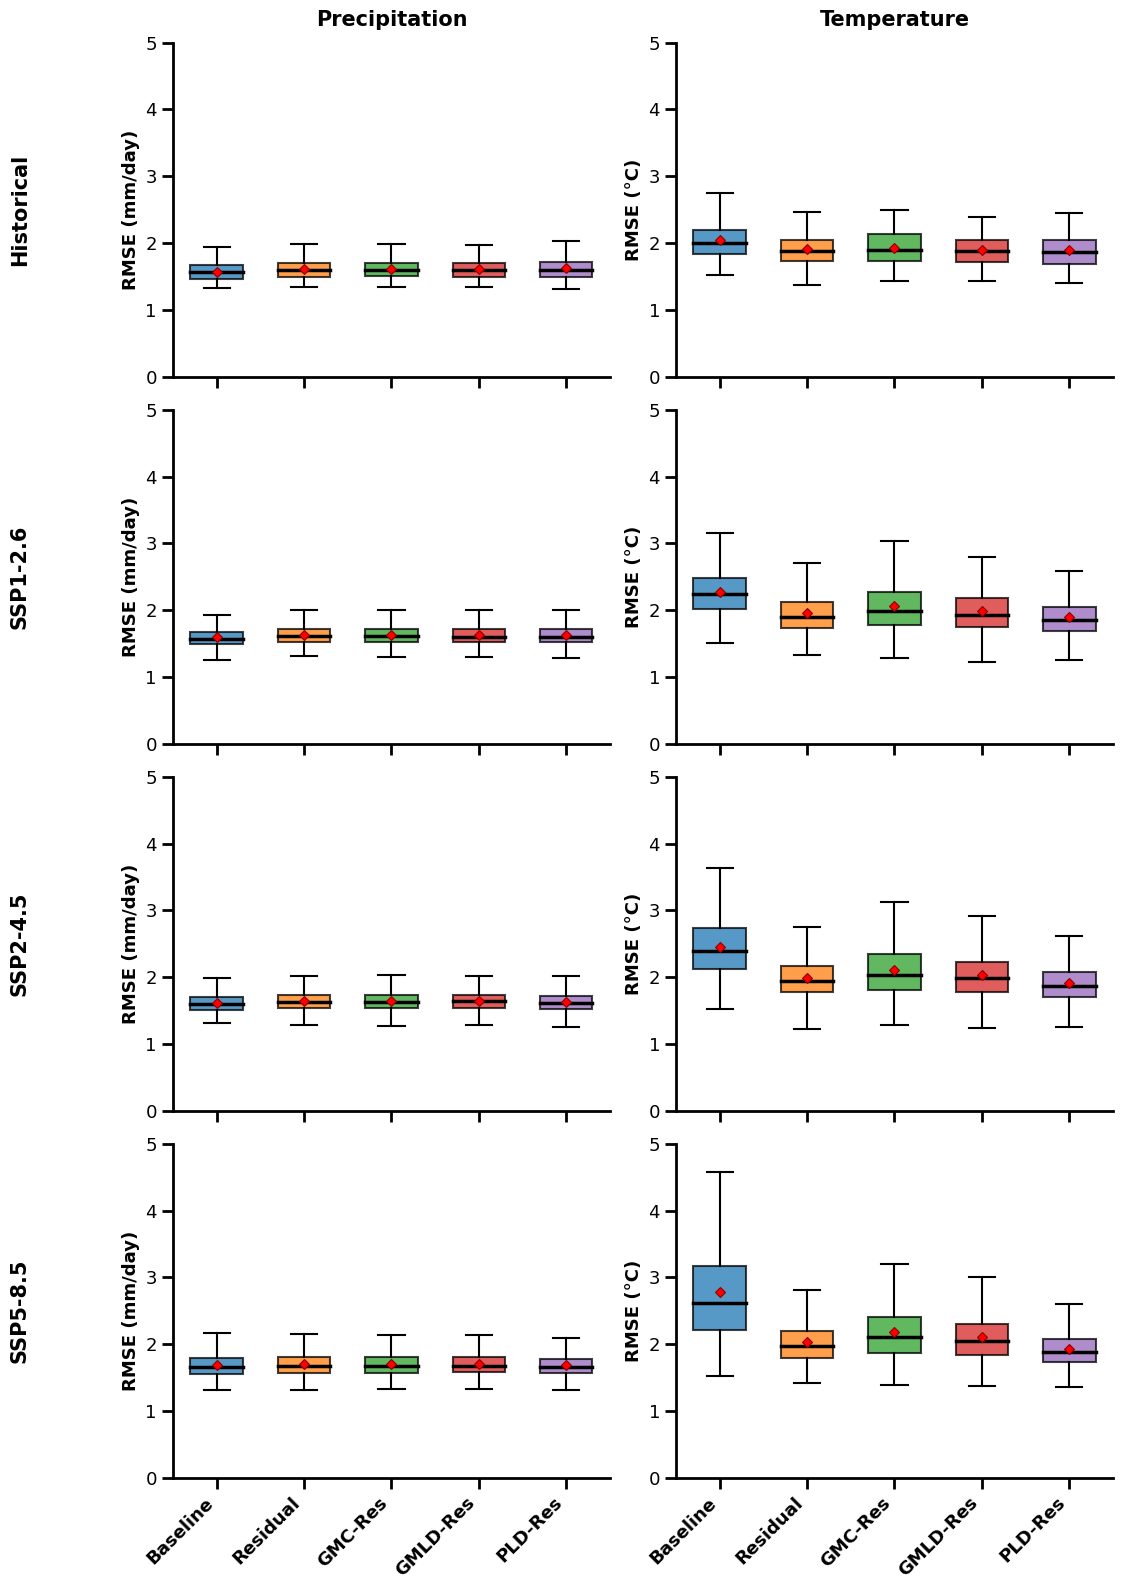

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path

# Configuration 
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

variables = ['pr', 'tas']
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']

# Model configurations with cleaner names
models = {
    'baseline': 'Baseline',           
    'raw_residual': 'Direct Residual',      
    'gmc_residual': 'GMC-Residual',           
    'gmld_residual': 'GMLD-Residual',         
    'pld_residual': 'PLD-Residual'            
}

# Map to actual data keys
model_mapping = {
    'baseline': 'pred_zscore_pixel',      
    'raw_residual': 'pred_raw',           
    'gmc_residual': 'pred_gma',           
    'gmld_residual': 'pred_gmt',          
    'pld_residual': 'pred_grid'           
}

# Variable configuration
var_config = {
    'pr': {'label': 'Precipitation', 'unit': 'mm/day'},
    'tas': {'label': 'Temperature', 'unit': '°C'}
}

# Y-axis configuration
y_axis_config = {
    'pr': {'lim': (0, 5), 'ticks': [0, 1, 2, 3, 4, 5]},
    'tas': {'lim': (0, 5), 'ticks': [0, 1, 2, 3, 4, 5]}
}

# Scenario labels
scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Colors for models
model_colors = {
    'baseline': '#1f77b4',      
    'raw_residual': '#ff7f0e',  
    'gmc_residual': '#2ca02c',  
    'gmld_residual': '#d62728', 
    'pld_residual': '#9467bd'   
}

def compute_spatial_rmse_timeseries(predictions, groundtruth):
    """Calculate spatial RMSE for each time point."""
    n_time = predictions.shape[0]
    rmse_values = []
    
    for t in range(n_time):
        pred_2d = predictions[t].flatten()
        gt_2d = groundtruth[t].flatten()
        rmse = np.sqrt(np.mean((pred_2d - gt_2d)**2))
        rmse_values.append(rmse)
    
    return np.array(rmse_values)

# Load data and compute metrics
metrics = {var: {scen: {} for scen in scenarios} for var in variables}

for var in variables:
    for scenario in scenarios:
        # Load baseline results (original zscore_pixel)
        baseline_file = results_dir / f"{var}_evaluation_{scenario}.nc"
        if baseline_file.exists():
            ds_baseline = xr.open_dataset(baseline_file)
            gt_data = ds_baseline['groundtruth'].values
            
            if 'pred_zscore_pixel' in ds_baseline:
                pred_data = ds_baseline['pred_zscore_pixel'].values
                rmse_ts = compute_spatial_rmse_timeseries(pred_data, gt_data)
                metrics[var][scenario]['baseline'] = rmse_ts
        
        # Load residual model results
        residual_file = results_residual_dir / f"{var}_evaluation_{scenario}.nc"
        if residual_file.exists():
            ds_residual = xr.open_dataset(residual_file)
            gt_data = ds_residual['groundtruth'].values
            
            for model_key in ['raw_residual', 'gmc_residual', 'gmld_residual', 'pld_residual']:
                data_key = model_mapping[model_key]
                if data_key in ds_residual:
                    pred_data = ds_residual[data_key].values
                    rmse_ts = compute_spatial_rmse_timeseries(pred_data, gt_data)
                    metrics[var][scenario][model_key] = rmse_ts

# Create visualization
fig, axes = plt.subplots(4, 2, figsize=(12, 16))

for row, scenario in enumerate(scenarios):
    for col, var in enumerate(variables):
        ax = axes[row, col]
        
        # Prepare data for box plot
        box_data = []
        positions = []
        colors = []
        labels = []
        
        for i, (model_key, model_name) in enumerate(models.items()):
            if model_key in metrics[var][scenario]:
                rmse_data = metrics[var][scenario][model_key]
                box_data.append(rmse_data)
                positions.append(i + 1)
                colors.append(model_colors[model_key])
                labels.append(model_name)
        
        # Create box plot
        bp = ax.boxplot(box_data, positions=positions, widths=0.6,
                        patch_artist=True, showfliers=False,
                        medianprops=dict(color='black', linewidth=2.5),
                        boxprops=dict(linewidth=1.5),
                        whiskerprops=dict(linewidth=1.5),
                        capprops=dict(linewidth=1.5))
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.75)
        
        # Add mean marker (red diamond)
        for i, data_values in enumerate(box_data):
            mean_val = np.mean(data_values)
            ax.plot(positions[i], mean_val, 'D', color='red', 
                   markersize=5, zorder=10, markeredgecolor='darkred', 
                   markeredgewidth=0.8)
        
        # Formatting
        ax.set_xticks(positions)
        
        # X-axis labels only on bottom row
        if row == 3:
            # Use abbreviated labels for x-axis
            x_labels = ['Baseline', 'Residual', 'GMC-Res', 'GMLD-Res', 'PLD-Res']
            ax.set_xticklabels(x_labels[:len(positions)], 
                              rotation=45, ha='right', fontsize=11, fontweight='bold')
        else:
            ax.set_xticklabels([])
        
        # Set y-axis limits and ticks
        ax.set_ylim(y_axis_config[var]['lim'])
        ax.set_yticks(y_axis_config[var]['ticks'])
        
        # Y-axis label
        ax.set_ylabel(f'RMSE ({var_config[var]["unit"]})', 
                     fontsize=13, fontweight='bold')
        
        # Variable title on top row
        if row == 0:
            ax.set_title(var_config[var]['label'], 
                        fontsize=15, fontweight='bold', pad=12)
        
        # Scenario label on leftmost column
        if col == 0:
            ax.text(-0.35, 0.5, scenario_labels[scenario], 
                   transform=ax.transAxes,
                   fontsize=15, fontweight='bold',
                   rotation=90, va='center', ha='center',
                   color='black')
        
        # Show only left and bottom spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        
        # Tick parameters
        ax.tick_params(axis='both', which='major', 
                      labelsize=13, length=8, width=2, colors='black')

plt.tight_layout(rect=[0.06, 0, 1, 1.0])

# Save figure
output_file = figures_dir / "11_spatial_rmse_boxplots_residual.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')


# Figure 4

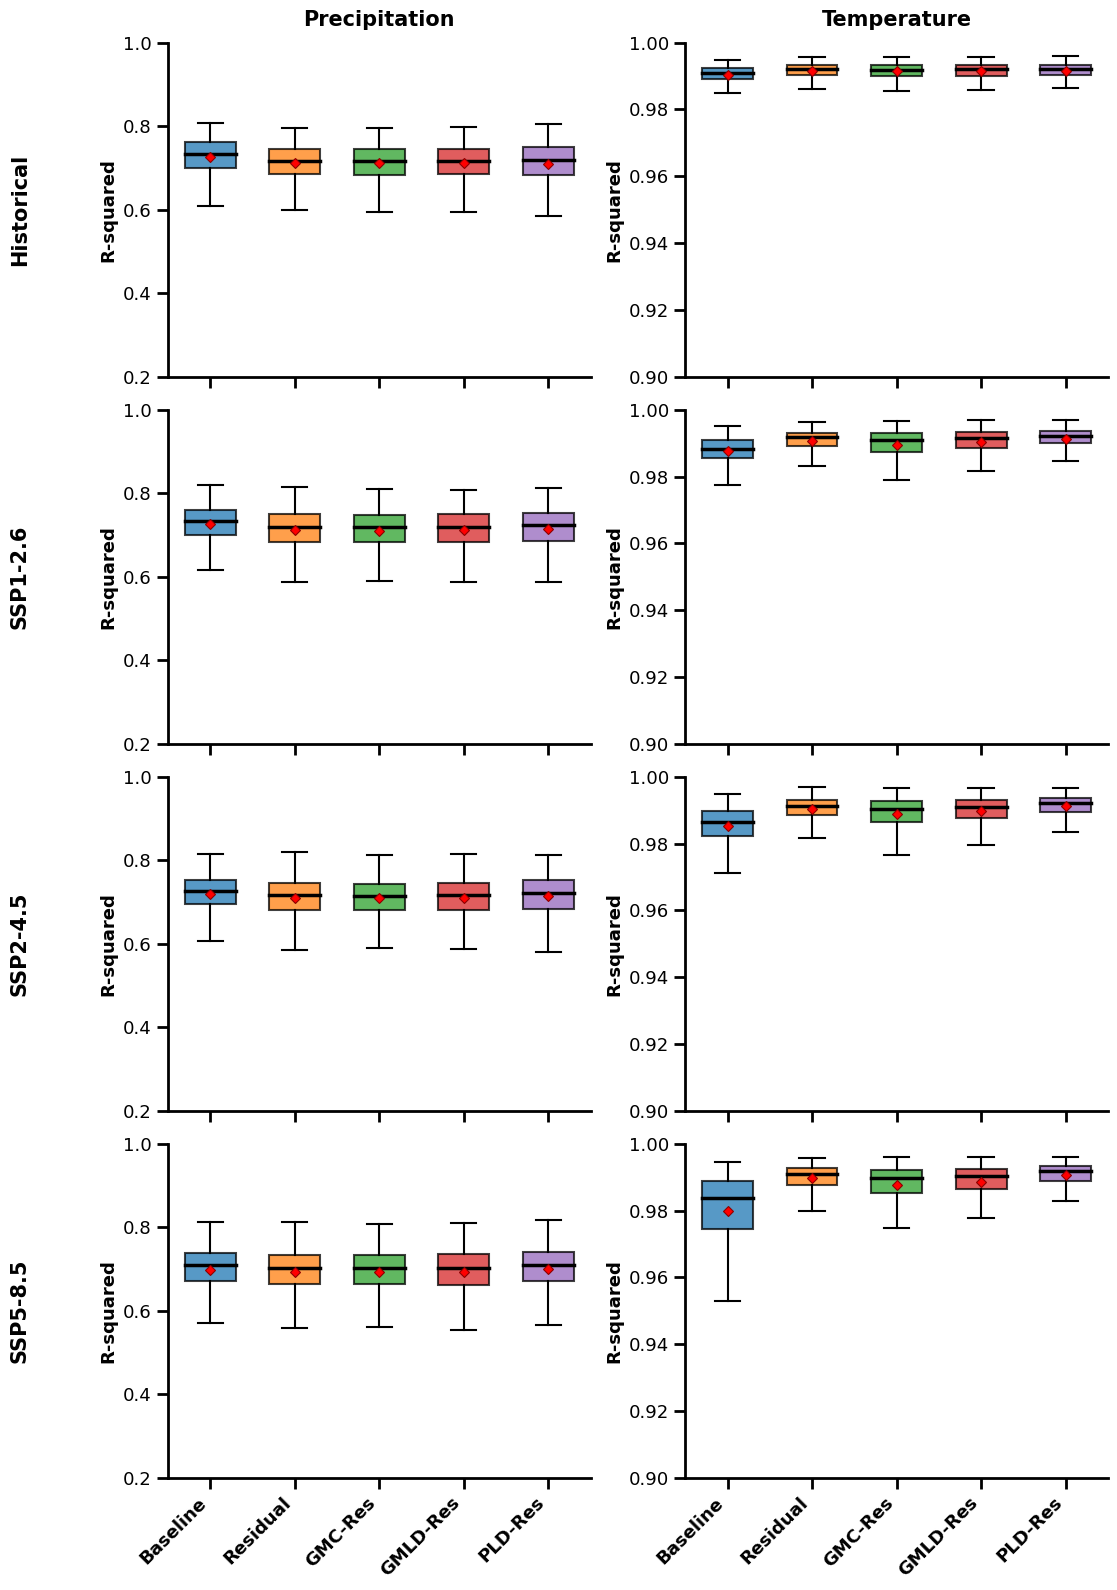

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path

# Configuration
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

variables = ['pr', 'tas']
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']

# Model configurations 
models = {
    'baseline': 'Baseline',           
    'raw_residual': 'Direct Residual',      
    'gmc_residual': 'GMC-Residual',           
    'gmld_residual': 'GMLD-Residual',         
    'pld_residual': 'PLD-Residual'            
}

# Map to actual data keys
model_mapping = {
    'baseline': 'pred_zscore_pixel',      
    'raw_residual': 'pred_raw',           
    'gmc_residual': 'pred_gma',           
    'gmld_residual': 'pred_gmt',          
    'pld_residual': 'pred_grid'           
}

# Variable configuration
var_config = {
    'pr': {'label': 'Precipitation', 'unit': ''},
    'tas': {'label': 'Temperature', 'unit': ''}
}

# Y-axis configuration for R²
y_axis_config = {
    'pr': {'lim': (0.2, 1), 'ticks': [0.2, 0.4, 0.6, 0.8, 1.0]},
    'tas': {'lim': (0.9, 1), 'ticks': [0.90, 0.92, 0.94, 0.96, 0.98, 1.0]}
}

# Scenario labels
scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Colors for models
model_colors = {
    'baseline': '#1f77b4',      
    'raw_residual': '#ff7f0e',  
    'gmc_residual': '#2ca02c',  
    'gmld_residual': '#d62728', 
    'pld_residual': '#9467bd'   
}

def compute_spatial_r2_timeseries(predictions, groundtruth):
    """
    Calculate spatial R² (coefficient of determination) for each time point.
    
    R² = 1 - SS_res / SS_tot
    where SS_res = sum((y - y_pred)^2)
          SS_tot = sum((y - y_mean)^2)
    """
    n_time = predictions.shape[0]
    r2_values = []
    
    for t in range(n_time):
        pred_2d = predictions[t].flatten()
        gt_2d = groundtruth[t].flatten()
        
        # Calculate R²
        ss_res = np.sum((gt_2d - pred_2d)**2)
        ss_tot = np.sum((gt_2d - np.mean(gt_2d))**2)
        
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        r2_values.append(r2)
    
    return np.array(r2_values)

# Load data and compute metrics
metrics = {var: {scen: {} for scen in scenarios} for var in variables}

for var in variables:
    for scenario in scenarios:
        # Load baseline results (original zscore_pixel)
        baseline_file = results_dir / f"{var}_evaluation_{scenario}.nc"
        if baseline_file.exists():
            ds_baseline = xr.open_dataset(baseline_file)
            gt_data = ds_baseline['groundtruth'].values
            
            if 'pred_zscore_pixel' in ds_baseline:
                pred_data = ds_baseline['pred_zscore_pixel'].values
                r2_ts = compute_spatial_r2_timeseries(pred_data, gt_data)
                metrics[var][scenario]['baseline'] = r2_ts
        
        # Load residual model results
        residual_file = results_residual_dir / f"{var}_evaluation_{scenario}.nc"
        if residual_file.exists():
            ds_residual = xr.open_dataset(residual_file)
            gt_data = ds_residual['groundtruth'].values
            
            for model_key in ['raw_residual', 'gmc_residual', 'gmld_residual', 'pld_residual']:
                data_key = model_mapping[model_key]
                if data_key in ds_residual:
                    pred_data = ds_residual[data_key].values
                    r2_ts = compute_spatial_r2_timeseries(pred_data, gt_data)
                    metrics[var][scenario][model_key] = r2_ts

# Create visualization
fig, axes = plt.subplots(4, 2, figsize=(12, 16))

for row, scenario in enumerate(scenarios):
    for col, var in enumerate(variables):
        ax = axes[row, col]
        
        # Prepare data for box plot
        box_data = []
        positions = []
        colors = []
        labels = []
        
        for i, (model_key, model_name) in enumerate(models.items()):
            if model_key in metrics[var][scenario]:
                r2_data = metrics[var][scenario][model_key]
                box_data.append(r2_data)
                positions.append(i + 1)
                colors.append(model_colors[model_key])
                labels.append(model_name)
        
        # Create box plot
        bp = ax.boxplot(box_data, positions=positions, widths=0.6,
                        patch_artist=True, showfliers=False,
                        medianprops=dict(color='black', linewidth=2.5),
                        boxprops=dict(linewidth=1.5),
                        whiskerprops=dict(linewidth=1.5),
                        capprops=dict(linewidth=1.5))
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.75)
        
        # Add mean marker (red diamond)
        for i, data_values in enumerate(box_data):
            mean_val = np.mean(data_values)
            ax.plot(positions[i], mean_val, 'D', color='red', 
                   markersize=5, zorder=10, markeredgecolor='darkred', 
                   markeredgewidth=0.8)
        
        # Formatting
        ax.set_xticks(positions)
        
        # X-axis labels only on bottom row
        if row == 3:
            x_labels = ['Baseline', 'Residual', 'GMC-Res', 'GMLD-Res', 'PLD-Res']
            ax.set_xticklabels(x_labels[:len(positions)], 
                              rotation=45, ha='right', fontsize=11, fontweight='bold')
        else:
            ax.set_xticklabels([])
        
        # Set y-axis limits and ticks
        ax.set_ylim(y_axis_config[var]['lim'])
        ax.set_yticks(y_axis_config[var]['ticks'])
        
        # Y-axis label
        ax.set_ylabel('R-squared', fontsize=13, fontweight='bold')
        
        # Variable title on top row
        if row == 0:
            ax.set_title(var_config[var]['label'], 
                        fontsize=15, fontweight='bold', pad=12)
        
        # Scenario label on leftmost column
        if col == 0:
            ax.text(-0.35, 0.5, scenario_labels[scenario], 
                   transform=ax.transAxes,
                   fontsize=15, fontweight='bold',
                   rotation=90, va='center', ha='center',
                   color='black')
        
        # Show only left and bottom spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        
        # Tick parameters
        ax.tick_params(axis='both', which='major', 
                      labelsize=13, length=8, width=2, colors='black')

plt.tight_layout(rect=[0.06, 0, 1, 1.0])

# Save figure
output_file = figures_dir / "12_spatial_r2_boxplots_residual.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
